# GNOD Project Model building

In [1]:
# import libraries and dataset
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn import cluster 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import random

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from random import randint
from time import sleep

from pandas import json_normalize
pd.set_option("display.max_columns", 0) #no limit to cols we want to see

import pickle

playlist = pd.read_pickle('playlist.pkl')

In [2]:
playlist.columns

Index(['track.name', 'name', 'song_id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [3]:
# remove either song_id or id as they're the same
playlist.drop('id', axis=1, inplace=True)
playlist.columns

Index(['track.name', 'name', 'song_id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

#### Preparing our X

In [4]:
# test scatter
X = playlist[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

X

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.482,0.721,0,-6.839,1,0.0321,0.731000,0.000000,0.1890,0.557,95.263,369600,4
1,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.016200,0.1380,0.767,116.835,300977,4
2,0.364,0.457,4,-14.162,0,0.0675,0.290000,0.000106,0.9220,0.175,163.219,337413,4
3,0.398,0.413,1,-10.934,1,0.0388,0.082200,0.000025,0.0891,0.331,133.574,219147,4
4,0.518,0.756,10,-10.851,1,0.0915,0.735000,0.000062,0.3170,0.968,166.429,160893,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10925,0.332,0.707,7,-12.698,1,0.0361,0.000012,0.006120,0.1100,0.652,144.815,199467,4
10926,0.464,0.749,6,-8.564,1,0.4800,0.224000,0.000046,0.3510,0.879,181.121,201800,4
10927,0.694,0.710,2,-9.793,1,0.3400,0.527000,0.001350,0.0697,0.415,119.964,183040,4
10928,0.332,0.800,1,-9.746,1,0.0326,0.000368,0.001600,0.0850,0.832,149.240,222160,4


In [5]:
# as there's no target, we don't train-test split
scaler = StandardScaler()
X_prep = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_prep, columns = X.columns)

In [6]:
X_scaled = pd.DataFrame(X_prep, columns = X.columns)
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,10930.0,2.645845e-16,1.000046,-2.971740,-0.689750,0.021159,0.726169,2.448871
energy,10930.0,-3.640475e-17,1.000046,-2.647650,-0.702124,0.148611,0.815433,1.645733
key,10930.0,-8.142313e-17,1.000046,-1.493586,-0.932381,-0.090573,1.031837,1.593042
loudness,10930.0,-1.358677e-16,1.000046,-13.182100,-0.612969,0.151144,0.743365,2.721606
mode,10930.0,-1.098643e-16,1.000046,-1.509093,-1.509093,0.662650,0.662650,0.662650
speechiness,10930.0,-8.321086e-17,1.000046,-0.653669,-0.517792,-0.389195,-0.014623,10.403311
acousticness,10930.0,-1.300170e-18,1.000046,-0.939245,-0.864166,-0.434619,0.774638,2.125436
instrumentalness,10930.0,-1.235161e-17,1.000046,-0.437900,-0.437894,-0.436731,-0.323794,3.747045
liveness,10930.0,-2.951385e-16,1.000046,-1.177969,-0.636334,-0.397861,0.364733,5.185878
valence,10930.0,-3.640475e-16,1.000046,-2.214408,-0.789841,0.062533,0.825184,1.681637


#### Finding optimal k

100%|██████████| 23/23 [00:08<00:00,  2.86it/s]


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

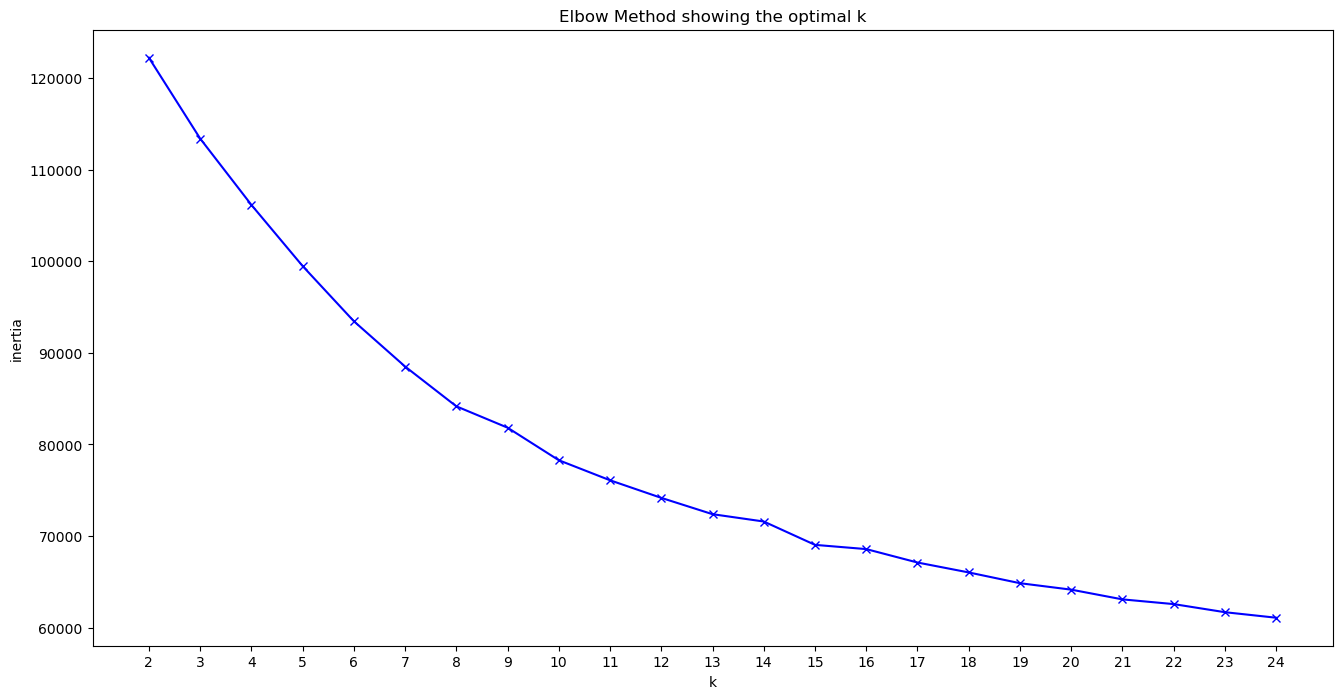

In [26]:

K = range(2, 25) #range of clusterings, from 2 to 19
inertia = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:55<00:00,  2.42s/it]


Text(0.5, 1.0, 'Slhouette score showing the optimal k')

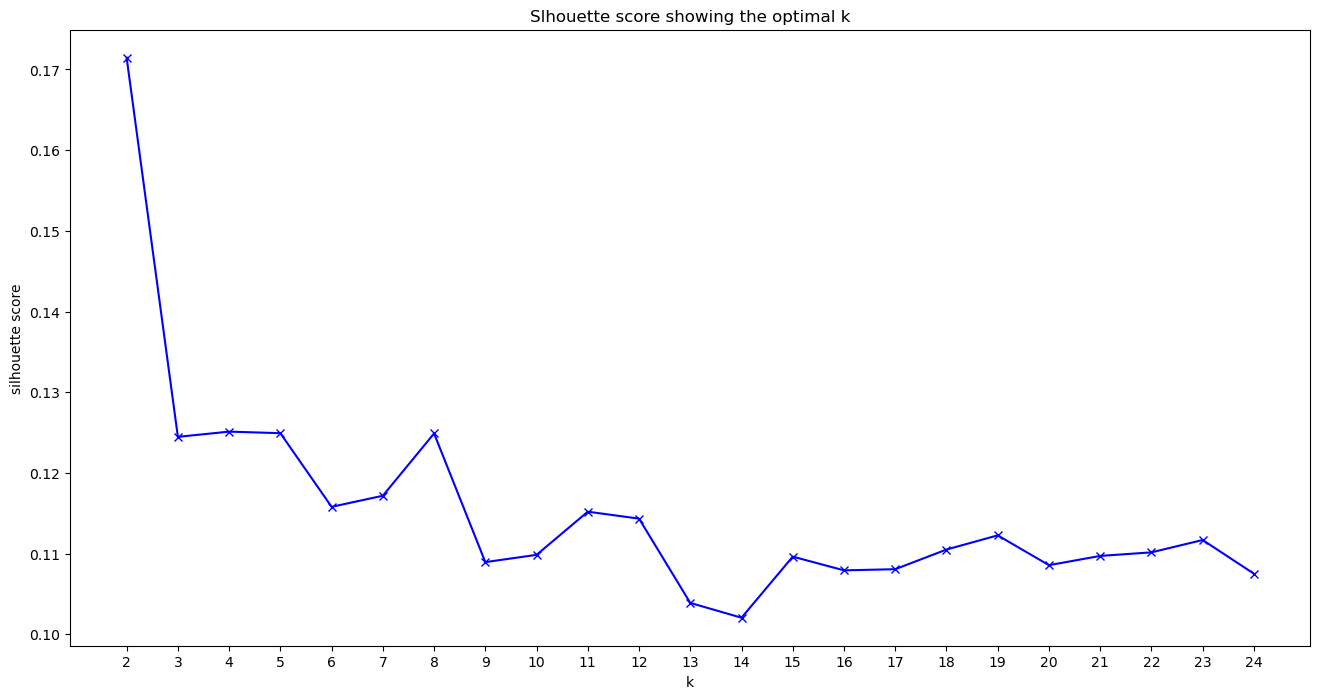

In [7]:
K = range(2, 25)
silhouette = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled)
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

**Optimal vals:** Our optimal k could be 8, 4 as a 2nd option, and 11 as 3rd.

#### K-means fit & plot

##### `k = 8`

In [14]:
# 8 clusters try
# fitting kmeans
kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(X_scaled)

KMeans(random_state=1234)

In [15]:
# Predicting / assigning the clusters:
predict_8 = kmeans.predict(X_scaled)
predict_8

# Check the size of the clusters
k_8clusters = pd.Series(predict_8).sort_index()
k_8clusters

0        2
1        2
2        4
3        4
4        2
        ..
10925    4
10926    6
10927    6
10928    4
10929    2
Length: 10930, dtype: int32

##### `k = 4`

In [8]:
# 4 clusters try
# fitting kmeans
kmeans4 = KMeans(n_clusters=4, random_state=1234)
kmeans4.fit(X_scaled)

KMeans(n_clusters=4, random_state=1234)

In [9]:
# Predicting / assigning the clusters:
predict_4 = kmeans4.predict(X_scaled)

# Check the size of the clusters
k_4clusters = pd.Series(predict_4).sort_index()
k_4clusters

0        1
1        1
2        3
3        3
4        1
        ..
10925    1
10926    1
10927    1
10928    1
10929    1
Length: 10930, dtype: int32

##### `k = 11`

In [10]:
# 11 clusters try
# fitting kmeans
kmeans11 = KMeans(n_clusters=11, random_state=1234)
kmeans11.fit(X_scaled)

KMeans(n_clusters=11, random_state=1234)

In [11]:
# Predicting / assigning the clusters:
predict_11 = kmeans11.predict(X_scaled)

# Check the size of the clusters
k_11clusters = pd.Series(predict_11).sort_index()
k_11clusters

0         6
1         6
2        10
3         3
4         1
         ..
10925     3
10926     2
10927     2
10928     6
10929     1
Length: 10930, dtype: int32

#### Save clusters work to playlist dataset

In [19]:
# add series of clusters to the og df
playlist_test5 = playlist.assign(cluster = k_8clusters, extra_cluster = k_11clusters)
playlist_test5

,track.name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,cluster,extra_cluster
0,Like a Rolling Stone,Bob Dylan,3AhXZa8sUQht0UEdBJgpGc,0.482,0.721,0,-6.839,1,0.0321,0.731000,0.000000,0.1890,0.557,95.263,audio_features,spotify:track:3AhXZa8sUQht0UEdBJgpGc,https://api.spotify.com/v1/tracks/3AhXZa8sUQht...,https://api.spotify.com/v1/audio-analysis/3AhX...,369600,4,2,6
1,Smells Like Teen Spirit,Nirvana,3oTlkzk1OtrhH8wBAduVEi,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.016200,0.1380,0.767,116.835,audio_features,spotify:track:3oTlkzk1OtrhH8wBAduVEi,https://api.spotify.com/v1/tracks/3oTlkzk1Otrh...,https://api.spotify.com/v1/audio-analysis/3oTl...,300977,4,2,6
2,A Day In The Life - Remastered,The Beatles,3ZFBeIyP41HhnALjxWy1pR,0.364,0.457,4,-14.162,0,0.0675,0.290000,0.000106,0.9220,0.175,163.219,audio_features,spotify:track:3ZFBeIyP41HhnALjxWy1pR,https://api.spotify.com/v1/tracks/3ZFBeIyP41Hh...,https://api.spotify.com/v1/audio-analysis/3ZFB...,337413,4,4,10
3,Good Vibrations (Mono),The Beach Boys,5Qt4Cc66g24QWwGP3YYV9y,0.398,0.413,1,-10.934,1,0.0388,0.082200,0.000025,0.0891,0.331,133.574,audio_features,spotify:track:5Qt4Cc66g24QWwGP3YYV9y,https://api.spotify.com/v1/tracks/5Qt4Cc66g24Q...,https://api.spotify.com/v1/audio-analysis/5Qt4...,219147,4,4,3
4,Johnny B Goode,Chuck Berry,7MH2ZclofPlTrZOkPzZKhK,0.518,0.756,10,-10.851,1,0.0915,0.735000,0.000062,0.3170,0.968,166.429,audio_features,spotify:track:7MH2ZclofPlTrZOkPzZKhK,https://api.spotify.com/v1/tracks/7MH2ZclofPlT...,https://api.spotify.com/v1/audio-analysis/7MH2...,160893,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10925,Into The Valley,Skids,2QSD3K3b3BJ8DPhGhQfDPW,0.332,0.707,7,-12.698,1,0.0361,0.000012,0.006120,0.1100,0.652,144.815,audio_features,spotify:track:2QSD3K3b3BJ8DPhGhQfDPW,https://api.spotify.com/v1/tracks/2QSD3K3b3BJ8...,https://api.spotify.com/v1/audio-analysis/2QSD...,199467,4,4,3
10926,Tonight's Da Night,Redman,49XnDVsYOHgV4gFZeCojKj,0.464,0.749,6,-8.564,1,0.4800,0.224000,0.000046,0.3510,0.879,181.121,audio_features,spotify:track:49XnDVsYOHgV4gFZeCojKj,https://api.spotify.com/v1/tracks/49XnDVsYOHgV...,https://api.spotify.com/v1/audio-analysis/49Xn...,201800,4,6,2
10927,Figure 8,FKA twigs,5Y9IIH8Xmo1nuk0gfFjc4Q,0.694,0.710,2,-9.793,1,0.3400,0.527000,0.001350,0.0697,0.415,119.964,audio_features,spotify:track:5Y9IIH8Xmo1nuk0gfFjc4Q,https://api.spotify.com/v1/tracks/5Y9IIH8Xmo1n...,https://api.spotify.com/v1/audio-analysis/5Y9I...,183040,4,6,2
10928,Like An Angel,The Mighty Lemon Drops,0ya0JYEFoXNviB8RMeHDtW,0.332,0.800,1,-9.746,1,0.0326,0.000368,0.001600,0.0850,0.832,149.240,audio_features,spotify:track:0ya0JYEFoXNviB8RMeHDtW,https://api.spotify.com/v1/tracks/0ya0JYEFoXNv...,https://api.spotify.com/v1/audio-analysis/0ya0...,222160,4,4,6


In [20]:
# save into pickle to work for pred model
playlist_test5.to_pickle('playlist_2clusters.pkl')

In [133]:
# 1st iteration pt 2 - get a playlist song and recommend another from its cluster
query = 'Figure 8'

if query.lower() in playlist_test5['track.name'].values:
    query_row = playlist_test5[playlist_test5['track.name'].isin([query])]

    group = playlist_test5[playlist_test5['cluster'].values == query_row['cluster'].values]
    group
    # pick random number to get random song and artist
    random_idx = random.randint(0, len(group)-1)

    # rec response    
    print("-Paris Hilton voice- That's hot! Here's another recommendation for you:", playlist_test5['track.name'].iloc[random_idx], 
    "by", 
    playlist_test5['name'].iloc[random_idx])
else:
    print('You gotta broaden your horizons sweatie~')

-Paris Hilton voice- That's hot! Here's another recommendation for you: Lose Yourself - Soundtrack Version by Eminem


In [21]:
# save scaler and model for rec notebook
# pickle.dump(kmeans,open('kmeans8.sav','wb'))
# pickle.dump(scaler,open('scaler.sav','wb'))
pickle.dump(kmeans11,open('kmeans11.sav','wb'))

***

#### Spotify query search test

In [64]:
# spotify api auth
# auth path with creds text file
secrets_file = open('secrets.txt','r') 

# read and split to ready for creds
string = secrets_file.read()
string.split('\n')

# use this to make it a dictionary
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

# spotipy init with user credentials
sp = spotipy.Spotify(auth_manager = SpotifyClientCredentials(client_id = secrets_dict['clientid'],
                                                            client_secret = secrets_dict['clientsecret']))

In [134]:
# function for the query
# clean query to use it with our model (we need the audio feats)
def clean_query(user_input, df2):
    # look up the song
    query = sp.search(q = user_input, type = 'track', limit = 1)

    #get the song id to look up audio feats
    song_id = query['tracks']['items'][0]['id']
    audio_feats = sp.audio_features(song_id)

    # normalise and get only numericals
    au_norm = json_normalize(audio_feats)
    song_df = au_norm.select_dtypes(np.number)

    # scale
    song_scaled = scaler.transform(song_df)
    X_song_scaled = pd.DataFrame(song_scaled, columns = song_df.columns)

    # then predict
    song_predict = kmeans.predict(X_song_scaled)

    # now point it to the playlist and get its cluster buddies
    group = df2[df2['k_8clusters'] == song_predict[0]]

    # get a random song from that cluster
    random_idx = random.randint(0, len(group)-1)
    print("We don't have that babes, but here's something similar:", 
        group['track.name'].iloc[random_idx],
        "by",
        group['name'].iloc[random_idx])


In [95]:
# test with user input
song = input('Gimme a song baybeh')
clean_query(song, playlist_test5)


We don't have that babes, but here's something similar: It's A Man's Man's Man's World by James Brown


In [85]:
# now point it to the playlist and get its cluster buddies
group = playlist_test5[playlist_test5['k_8clusters'] == song_predict[0]]

# get a random song from that cluster
random_idx = random.randint(0, len(group)-1)
print("We don't have that babes, but here's something similar:", 
      group['track.name'].iloc[random_idx],
      "by",
      group['name'].iloc[random_idx])

,track.name,name,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,k_8clusters,k_4clusters
30,A Change Is Gonna Come,Sam Cooke,0RFKuagqUgR4X8C1QneCCq,0.214,0.400,10,-10.042,1,0.0342,0.756000,0.000000,0.3250,0.5080,169.683,audio_features,0RFKuagqUgR4X8C1QneCCq,spotify:track:0RFKuagqUgR4X8C1QneCCq,https://api.spotify.com/v1/tracks/0RFKuagqUgR4...,https://api.spotify.com/v1/audio-analysis/0RFK...,191160,3,7,3
36,Strange Fruit,Billie Holiday,2sq8Rz7pspqExxUF0gPaJ7,0.304,0.104,10,-15.835,0,0.0313,0.963000,0.000291,0.1770,0.0608,81.020,audio_features,2sq8Rz7pspqExxUF0gPaJ7,spotify:track:2sq8Rz7pspqExxUF0gPaJ7,https://api.spotify.com/v1/tracks/2sq8Rz7pspqE...,https://api.spotify.com/v1/audio-analysis/2sq8...,189360,3,7,3
72,House of the Rising Sun,The Animals,3XC7Jd6SfrQYKZJ6inyRHK,0.316,0.484,9,-9.110,0,0.0308,0.000334,0.004450,0.0912,0.2990,117.363,audio_features,3XC7Jd6SfrQYKZJ6inyRHK,spotify:track:3XC7Jd6SfrQYKZJ6inyRHK,https://api.spotify.com/v1/tracks/3XC7Jd6SfrQY...,https://api.spotify.com/v1/audio-analysis/3XC7...,269907,3,7,0
138,I'm So Lonesome I Could Cry - Single Version,Hank Williams,3l49MeO0nNZhBj1IfYWB5w,0.667,0.216,4,-12.918,1,0.0298,0.888000,0.002500,0.1320,0.6590,111.088,audio_features,3l49MeO0nNZhBj1IfYWB5w,spotify:track:3l49MeO0nNZhBj1IfYWB5w,https://api.spotify.com/v1/tracks/3l49MeO0nNZh...,https://api.spotify.com/v1/audio-analysis/3l49...,166000,3,7,3
153,Be-Bop-A-Lula,Gene Vincent & His Blue Caps,0TMrV95mP7sDlvbE4iVfKP,0.607,0.561,9,-10.099,1,0.0425,0.421000,0.000000,0.2980,0.8410,127.638,audio_features,0TMrV95mP7sDlvbE4iVfKP,spotify:track:0TMrV95mP7sDlvbE4iVfKP,https://api.spotify.com/v1/tracks/0TMrV95mP7sD...,https://api.spotify.com/v1/audio-analysis/0TMr...,157207,3,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10874,In the Pines,Bill Monroe & His Blue Grass Boys,5TxXTYSsLy4PUtsSCQn8mz,0.507,0.198,3,-13.600,1,0.0260,0.910000,0.000116,0.2090,0.2340,96.016,audio_features,5TxXTYSsLy4PUtsSCQn8mz,spotify:track:5TxXTYSsLy4PUtsSCQn8mz,https://api.spotify.com/v1/tracks/5TxXTYSsLy4P...,https://api.spotify.com/v1/audio-analysis/5TxX...,201080,3,7,3
10879,I Go to Sleep,Pretenders,2mjlulQDhPV0CojxzKfJPC,0.611,0.222,6,-14.858,0,0.0280,0.871000,0.000031,0.0978,0.2120,76.534,audio_features,2mjlulQDhPV0CojxzKfJPC,spotify:track:2mjlulQDhPV0CojxzKfJPC,https://api.spotify.com/v1/tracks/2mjlulQDhPV0...,https://api.spotify.com/v1/audio-analysis/2mjl...,177133,3,7,3
10891,Indian Love Call,Jeanette MacDonald,5kdwgFoMweKxkX3BdvrJs4,0.186,0.298,5,-11.586,1,0.0401,0.961000,0.006710,0.1330,0.1630,84.408,audio_features,5kdwgFoMweKxkX3BdvrJs4,spotify:track:5kdwgFoMweKxkX3BdvrJs4,https://api.spotify.com/v1/tracks/5kdwgFoMweKx...,https://api.spotify.com/v1/audio-analysis/5kdw...,211253,1,7,3
10892,Indian Love Call,Nelson Eddy,5kdwgFoMweKxkX3BdvrJs4,0.186,0.298,5,-11.586,1,0.0401,0.961000,0.006710,0.1330,0.1630,84.408,audio_features,5kdwgFoMweKxkX3BdvrJs4,spotify:track:5kdwgFoMweKxkX3BdvrJs4,https://api.spotify.com/v1/tracks/5kdwgFoMweKx...,https://api.spotify.com/v1/audio-analysis/5kdw...,211253,1,7,3


In [89]:
# get a random song from that cluster
random_idx = random.randint(0, len(group)-1)
print("We don't have that babes, but here's something similar:", 
      group['track.name'].iloc[random_idx],
      "by",
      group['name'].iloc[random_idx])

We don't have that babes, but here's something similar: Swinging On A Star by Bing Crosby
